## Quora Question Pairs
Can we identify question pairs that have the same intent?
The goal is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

### Training Set

In [2]:
df_train = pd.read_csv('./quora/train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
print("Total Number of questions pairs in training data: {}".format(len(df_train)))
print("Duplicate Pairs %: {}".format(round(df_train['is_duplicate'].mean()*100,2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print("Total number of qustions in the training data: {}".format(len(np.unique(qids))))
print("Number of questions that appear multiple times: {}".format(np.sum(qids.value_counts() > 1)))

Total Number of questions pairs in training data: 404290
Duplicate Pairs %: 36.92
Total number of qustions in the training data: 537933
Number of questions that appear multiple times: 111780


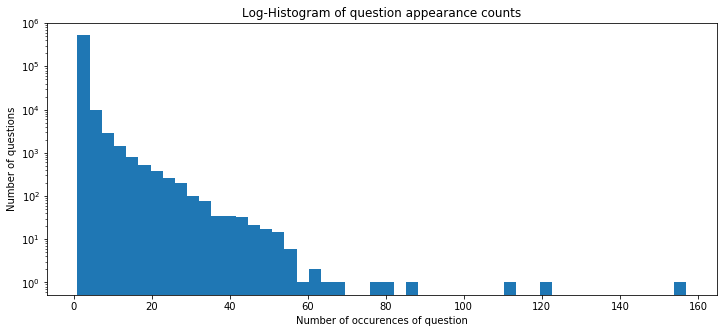

In [4]:
plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

### Test Submission

In [7]:
from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean() # Our predicted probability
print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

df_test = pd.read_csv('./quora/test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('naive_submission.csv', index=False)
sub.head()

Predicted score: 0.6585273839844354


,test_id,is_duplicate
0,0,0.369198
1,1,0.369198
2,2,0.369198
3,3,0.369198
4,4,0.369198


In [8]:
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [9]:
print("Total Number of question pairs for testing: ",len(df_test))

Total Number of question pairs for testing:  2345796


### Text Analysis

mean-train 59.82 std-train 31.96 mean-test 60.12 std-test 31.70 max-train 1169.00 max-test 1172.00


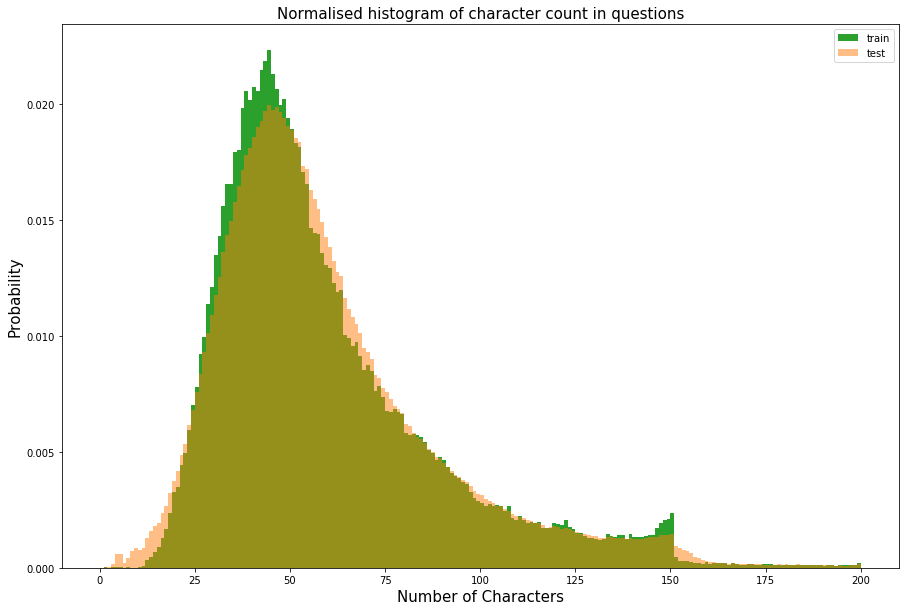

In [11]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_train['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)

plt.figure(figsize=(15,10))
plt.hist(dist_train, bins=200, range=[0,200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0,200], color=pal[1], alpha=0.5, normed=True,label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel("Number of Characters",fontsize=15)
plt.ylabel("Probability",fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))


Let's do the same for word count. I'll be using a naive method for splitting words (splitting on spaces instead of using a serious tokenizer), although this should still give us a good idea of the distribution.

/Users/ujjawalpathak/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


mean-train 11.06 std-train 5.89 mean-test 11.03 std-test 5.85 max-train 237.00 max-test 238.00


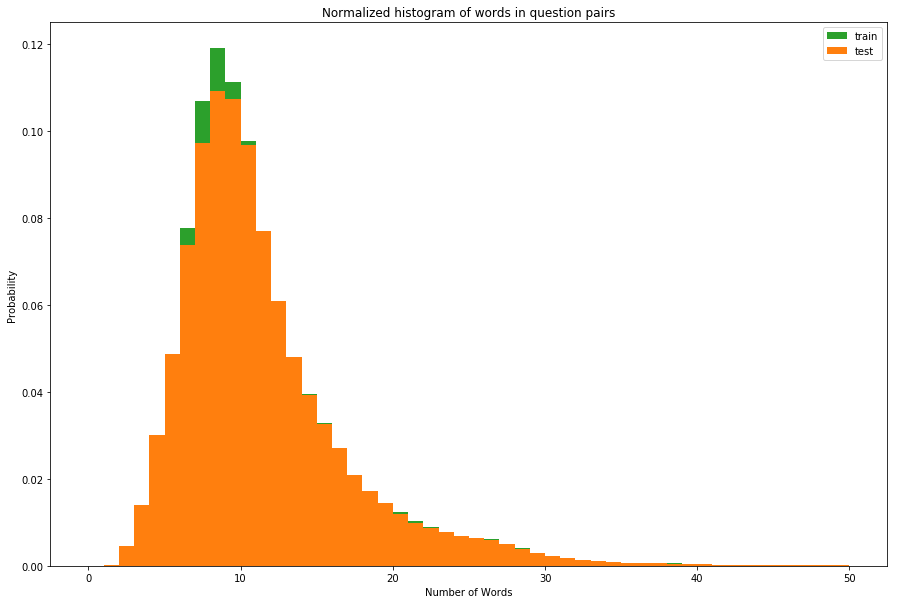

In [12]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15,10))
plt.hist(dist_train, bins=50, range=[0,50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0,50], color=pal[1], normed=True, label='test')
plt.title("Normalized histogram of words in question pairs")
plt.legend()
plt.xlabel("Number of Words")
plt.ylabel("Probability")

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
        dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))


We see a similar distribution for word count, with most questions being about 10 words long. It looks to me like the distribution of the training set seems more "pointy", while on the test set it is wider. Nevertheless, they are quite similar.

So what are the most common words? Let's take a look at a word cloud.


(-0.5, 1439.5, 1079.5, -0.5)

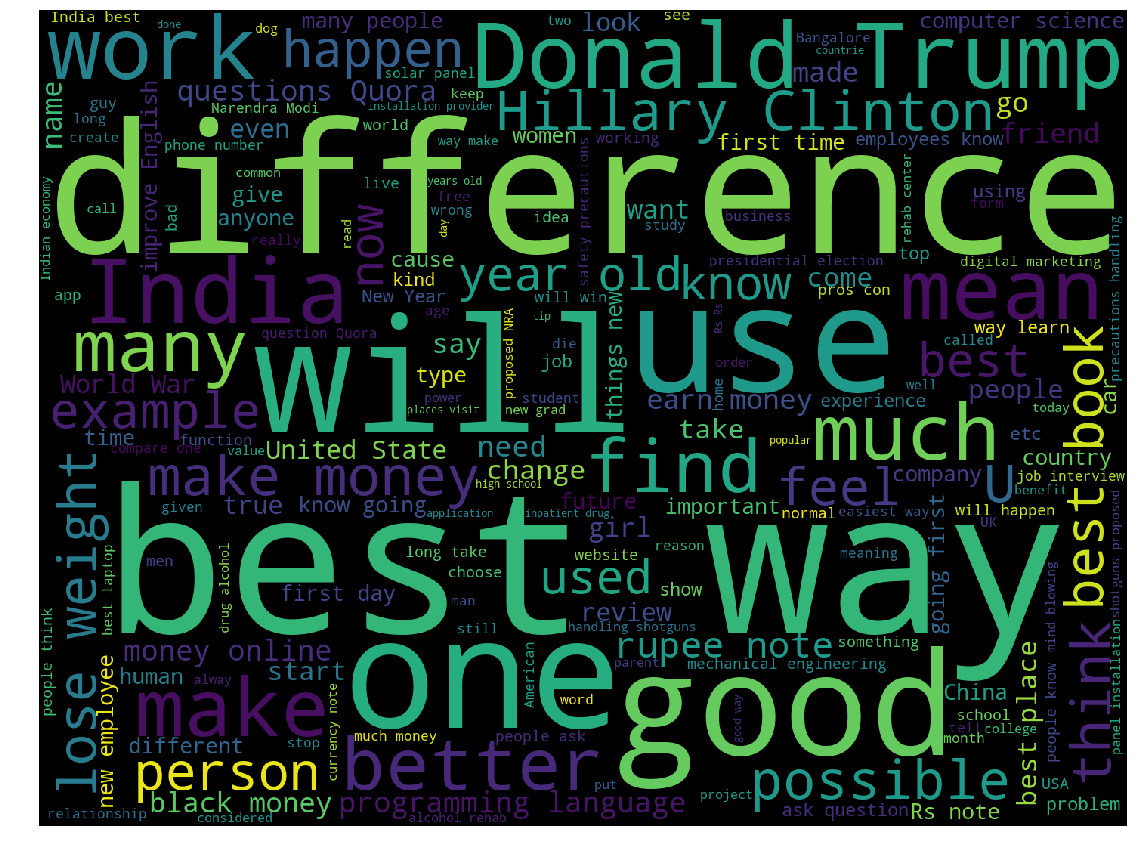

In [13]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(' '.join(train_qs.astype(str)))
plt.figure(figsize=(20,15))
plt.imshow(cloud)
plt.axis('off')

### Sematics Analysis

In [14]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


### Initial Feature Analysis

Before we create a model, we should take a look at how powerful some features are. I will start off with the word share feature from the benchmark model.


/Users/ujjawalpathak/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'word_match_share')

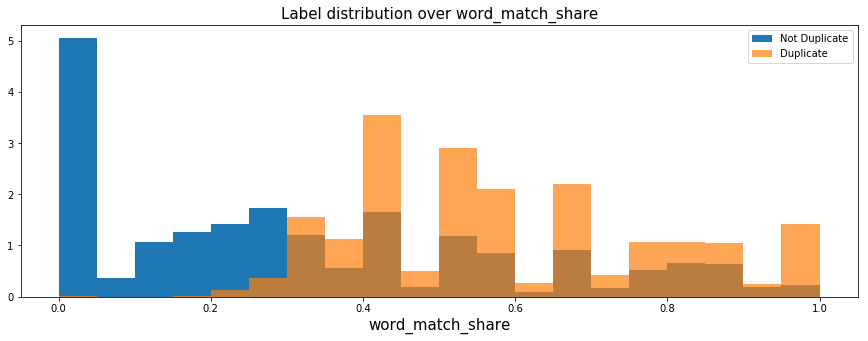

In [15]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stopwords:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stopwords:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

Here we can see that this feature has quite a lot of predictive power, as it is good at separating the duplicate questions from the non-duplicate ones. Interestingly, it seems very good at identifying questions which are definitely different, but is not so great at finding questions which are definitely duplicates.

### TF-IDF

In [16]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [17]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Least common words and weights: 


[('シ', 9.998000399920016e-05),
 ('し?', 9.998000399920016e-05),
 ('19-year-old.', 9.998000399920016e-05),
 ('1-855-425-3768', 9.998000399920016e-05),
 ('confederates', 9.998000399920016e-05),
 ('asahi', 9.998000399920016e-05),
 ('fab', 9.998000399920016e-05),
 ('109?', 9.998000399920016e-05),
 ('samrudi', 9.998000399920016e-05),
 ('fulfill?', 9.998000399920016e-05)]

In [22]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stopwords:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stopwords:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

/Users/ujjawalpathak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/ujjawalpathak/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


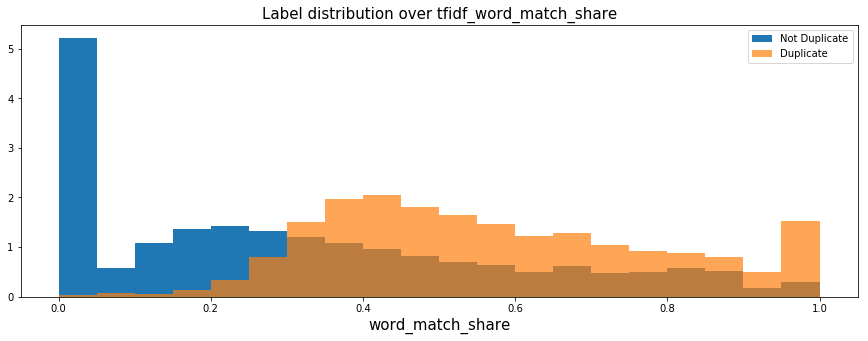

In [23]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15);

In [24]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.7804327049353577
   TFIDF AUC: 0.7704802292218704


So it looks like our TF-IDF actually got worse in terms of overall AUC, which is a bit disappointing. (I am using the AUC metric since it is unaffected by scaling and similar, so it is a good metric for testing the predictive power of individual features.

### Rebalancing The Data

In [25]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)

y_train = df_train['is_duplicate'].values

/Users/ujjawalpathak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/ujjawalpathak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [26]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


In [30]:
# Finally, we split some of the data off for validation
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

### XGBoost

In [31]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.68269	valid-logloss:0.683374
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.602603	valid-logloss:0.602534
[20]	train-logloss:0.545461	valid-logloss:0.545854
[30]	train-logloss:0.503691	valid-logloss:0.504447
[40]	train-logloss:0.471858	valid-logloss:0.473559
[50]	train-logloss:0.448647	valid-logloss:0.450074
[60]	train-logloss:0.430427	valid-logloss:0.431971
[70]	train-logloss:0.416376	valid-logloss:0.418081
[80]	train-logloss:0.405567	valid-logloss:0.407152
[90]	train-logloss:0.396786	valid-logloss:0.398583
[100]	train-logloss:0.3901	valid-logloss:0.391865
[110]	train-logloss:0.384277	valid-logloss:0.386504
[120]	train-logloss:0.380254	valid-logloss:0.382223
[130]	train-logloss:0.376898	valid-logloss:0.378791
[140]	train-logloss:0.374257	valid-logloss:0.376091
[150]	train-logloss:0.371744	valid-logloss:0.373982
[160]	train-logloss:0.370124	va

In [32]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False)